In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import PyComplexHeatmap as pch # Complex Heatmaps in Python

from multiprocessing import Pool # Multi-threading

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')

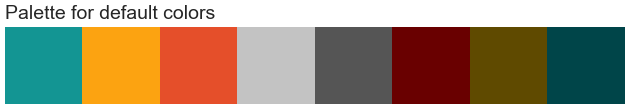

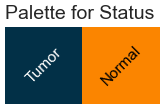

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

In [3]:
notebook_name = "4_ExploreProteoforms"
data_path = "./data/processed/"
input_path = f"./data/results/"
output_path = f"./data/results/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load the data

### Metadata

In [4]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
# Create UniqueNames: Group dictionary
unique_group_dict = metadata.set_index("UniqueNames")["Group"].to_dict()
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Protein Data from Spectronaut

In [5]:
spct_protein_data = feather.read_dataframe(
    "./data/prepared/NBL_directDIA_May2024_protein.feather"
)[metadata["UniqueNames"]]
# spct_protein_data = 10**(np.log10(spct_protein_data) + 1)
# np.power(np.log2(spct_protein_data) + 1, 2, out=spct_protein_data)
# If value is lower than 8 set NaN
spct_protein_data[spct_protein_data < 8] = np.nan
utils.print_shape(spct_protein_data, "Protein Level Data")
spct_protein_data.head()

Protein Level Data data has 11,603 rows and 20 columns


UniqueNames,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-80_Slot1-71,NBL-macro-79_Slot1-63,NBL-macro-82_Slot1-65,NBL-macro-108_Slot1-19,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-9_Slot1-43,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-107_Slot1-18,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28
PG.ProteinGroups,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,1855.4700,NaN,1893.8022,1361.8796,NaN,NaN,1884.7361,526.5074,1280.2126,199.4570,1166.2010,1978.5979,1213.7629,605.3120,578.8004,565.4798,321.8943,624.5991,1365.5754,1101.2657
A0A075B6I0,525.3407,NaN,409.3894,579.4897,NaN,NaN,NaN,361.1761,226.9183,549.2287,1115.9261,343.1009,530.3651,208.3897,279.4912,214.7908,NaN,500.8554,NaN,400.3751
P04211,NaN,NaN,NaN,839.0608,NaN,1779.4790,NaN,940.6215,414.1674,1182.6870,2709.7266,1901.9034,1062.8740,765.9526,452.6623,NaN,638.0793,1348.3998,NaN,1131.8433
A0A075B6J1,NaN,NaN,NaN,441.8033,NaN,NaN,NaN,NaN,NaN,NaN,483.1299,NaN,NaN,NaN,312.2646,NaN,NaN,NaN,NaN,NaN
A0A075B6J9,1105.1210,875.0184,847.3508,NaN,NaN,784.6713,666.8018,298.8053,202.3370,88.2952,1273.3090,978.8563,954.8919,566.9658,NaN,182.5788,290.6707,291.1244,NaN,221.3154


### Results Data

Extracting Clusters for ProteoForge's Proteoform Grouping


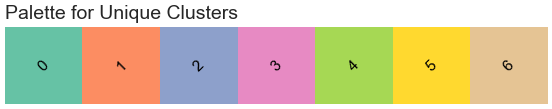

The clusters are extracted in 00h:01m:16s

Cluster ID Counts
   0 -> 1078240
   1 -> 798180
   2 -> 376400
   3 -> 81300
   4 -> 10800
   5 -> 800
   6 -> 80
Results data has 2,345,800 rows and 19 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight,oldCluster,pval,adj.pvalue,TumorRegulation,cluster_id,isSignificant
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943,1,0.0034,0.0132,Up,1,False
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935,0,0.0000,0.0000,Down,0,True
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682,2,0.0124,0.0400,Down,2,False
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957,0,0.1599,0.3053,Down,0,False
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717,0,0.4427,0.6194,Down,0,False


In [6]:
pThr = 10**-5

results_df = feather.read_dataframe(f"{input_path}results_df.feather")
# Get tumor regulation (Up in tumor, down in tumor)
tmp = results_df.reset_index().groupby([
    "Protein", "Peptide", "Condition"
])["log10(Intensity)"].mean().unstack()
tmp['TumorRegulation'] = (tmp['Tumor'] - tmp['Normal']).map(lambda x: 'Up' if x > 0 else 'Down')
results_df = results_df.merge(
    tmp['TumorRegulation'],
    on=["Protein", "Peptide"],
    how="left"
)

# Run the clustering if not already done or need to be updated
sT = utils.getTime()
print("Extracting Clusters for ProteoForge's Proteoform Grouping")
### Add cluster_ids
results_df = results_df.rename(columns={"cluster_id": "oldCluster"})
# Calculate the clustering 
def build_proteoform_groups_mp(protein):
    return utils.build_proteoform_groups(
        cur_protein=protein,
        data = results_df,
        sample_col="Sample",
        peptide_col="Peptide",
        protein_col="Protein",
        quant_col='Intensity',
        minSizePct=0.55, 
        absoluteMaxSize=3,
        corrMethod="kendall",
        distanceMethod="euclidean",
        linkageMethod="complete",
    )
from multiprocessing import Pool
with Pool(28) as p:
    clusters = p.map(build_proteoform_groups_mp, results_df['Protein'].unique())
clusters = pd.concat(clusters, axis=0, ignore_index=True)

# Create colormap for Clusters
uniqClusters = clusters["cluster_id"].sort_values().unique()
cluster_palette = sns.color_palette("Set2", len(uniqClusters)).as_hex()
cluster_palette = dict(zip(uniqClusters, cluster_palette))

plots.color_palette(
    cluster_palette,
    name="Unique Clusters",
    save=False
)

# Add the cluster palette to the test data
results_df = results_df.merge(
    clusters,
    on=["Protein", "Peptide"],
    how="left"
)
print(f"The clusters are extracted in {utils.prettyTimer(utils.getTime() - sT)}")
print()
utils.print_series(
    results_df["cluster_id"].value_counts(),
    header="Cluster ID Counts",
    tab=2
)

results_df = results_df.rename(columns={"adj_pval": "adj.pvalue"})
# Add the significance
results_df['isSignificant'] = results_df['adj.pvalue'] <= pThr  

utils.print_shape(results_df, "Results")
results_df.head()

### Expanded Info Data

In [7]:
expanded_info_data = feather.read_dataframe(f"{input_path}expanded_info_data.feather").reset_index()
expanded_info_data['isSignificant'] = expanded_info_data['adj.pvalue'] <= pThr
# Remove index columns if it exists
if 'index' in expanded_info_data.columns:
    expanded_info_data = expanded_info_data.drop(columns=['index'])

# Can be run if different clustering is run above
# Remove cluster_id if it exists
if 'cluster_id' in expanded_info_data.columns:
    expanded_info_data = expanded_info_data.rename(columns={"cluster_id": "oldCluster"})

# Add the cluster information
expanded_info_data = expanded_info_data.merge(
    clusters,
    on=["Protein", "Peptide"],
    how="left"
)
# Process the expanded_info_data
tmp = utils.process_data(expanded_info_data)
tmp['ProteoformGroup'] = tmp['new_dPFs']
tmp = tmp.drop(columns=['new_dPFs', 'cluster_id', 'oldCluster'])
tmp = tmp.rename(columns={"newClusters": "cluster_id"})
expanded_info_data = tmp

utils.print_shape(expanded_info_data, "Expanded Info")
expanded_info_data.head()

Expanded Info data has 117,215 rows and 17 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,0.0034,0.0132,False,0.0000,3
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0.0000,0.0000,True,1.0000,0
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,0.0124,0.0400,False,0.0000,6
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0.1599,0.3053,False,1.0000,0
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0.4427,0.6194,False,1.0000,0


In [8]:
# Pass the ProteoformGroup from expanded_info_data to the results_df['cluster_id']
results_df['cluster_id'] = results_df.set_index(['Protein', 'Peptide']).index.map(
    expanded_info_data.set_index(['Protein', 'Peptide'])['ProteoformGroup']
)

In [9]:
# Save the updated results_df and expanded_info_data
results_df.to_feather(f"{output_path}results_df_updated.feather")
expanded_info_data.to_feather(f"{output_path}expanded_info_data_updated.feather")

### UniProt Annotations Data

In [10]:
# UniProt Annotation Data
uniprot_annotation = feather.read_dataframe(f"{data_path}Uniprot_Annotation.feather")
utils.print_shape(uniprot_annotation, "Uniprot Annotation")
uniprot_annotation.head()

Uniprot Annotation data has 370,812 rows and 6 columns


,protein_id,feature,isoform_id,start,end,note
941,A0AV96,CHAIN,,1.0000,593.0000,RNA-binding protein 47
942,A0AV96,DOMAIN,,71.0000,149.0000,RRM 1
943,A0AV96,DOMAIN,,151.0000,233.0000,RRM 2
944,A0AV96,DOMAIN,,246.0000,318.0000,RRM 3
945,A0AV96,REGION,,1.0000,25.0000,Disordered


### Create Protein Info Data

In [11]:
# Create Protein Info 
protein_info = expanded_info_data.groupby("Protein").agg({
    "isCAP": "first",
    "geneName": "first",
    "Cov%": "max",
    "seqLength": "min",
    "Peptide": "count",
    "isSignificant": "sum"
}).reset_index()

withIsoforms = uniprot_annotation.loc[
    uniprot_annotation['feature']=='VAR_SEQ', 'protein_id'
].unique()

protein_info['hasIsoforms'] = protein_info['Protein'].isin(withIsoforms)

protein_info["Significant%"] = protein_info["isSignificant"] / protein_info["Peptide"] * 100
protein_info = protein_info.sort_values("Significant%", ascending=False).reset_index(drop=True)
protein_info.head()

,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%
0,Q6Y288,False,B3GLCT,16.4659,498,4,2,False,50.0000
1,Q9UMX1,True,SUFU,20.0413,484,4,2,True,50.0000
2,O43156,False,TTI1,8.5399,1089,4,2,False,50.0000
3,Q9NTW7,False,ZFP64,22.7907,645,4,2,True,50.0000
4,Q6P9F7,False,LRRC8B,6.6002,803,4,2,False,50.0000


# Exploring the Results

## Results in Numbers

### Visualizing the Number of Significant Peptides per Protein

Proteins with no significant peptides: 1091
Proteins with single significant peptides: 3222
Proteins with multiple significant peptides: 3171


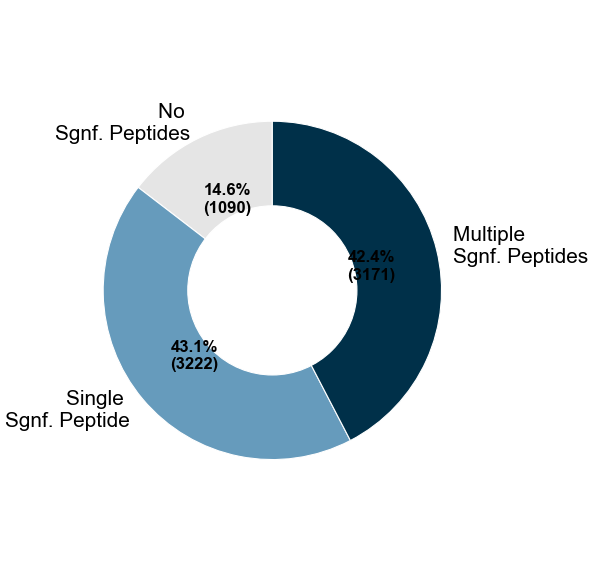

In [12]:
withOutSignificant_Peptide = (protein_info['isSignificant'] == 0).sum()
singleSignificant_Peptide = (protein_info['isSignificant'] == 1).sum()
multiSignificant_Peptide = (protein_info['isSignificant'] > 1).sum()
print(f"Proteins with no significant peptides: {withOutSignificant_Peptide}")
print(f"Proteins with single significant peptides: {singleSignificant_Peptide}")
print(f"Proteins with multiple significant peptides: {multiSignificant_Peptide}")

# Create a donut chart
data = [withOutSignificant_Peptide, singleSignificant_Peptide, multiSignificant_Peptide]
# Labels
labels = ["No \nSgnf. Peptides", "Single \nSgnf. Peptide", "Multiple \nSgnf. Peptides"]
# Colors
colors = ["#e5e5e5", "#669bbc", "#003049"]

_ = plots.donut_chart(
    data=data,
    labels=labels,
    colors=colors,
    circle_radius=0.5,
    save=True,
    filename="Proteins_Significant_Peptides",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Visualizing the Groups of Significant Peptides per Protein

In [13]:
## Subsetting for Proteins with Potential Proteolytic Activity
print(f"Number of Proteins Total: {len(protein_info)}")
proteinsWithSignf = protein_info.loc[protein_info['isSignificant'] > 0, "Protein"].to_list()
print(f"Number of Proteins with Significant Peptides: {len(proteinsWithSignf)}")
subset = expanded_info_data.loc[
    expanded_info_data['Protein'].isin(proteinsWithSignf), 
]
pfg_group = subset.groupby(['Protein', 'ProteoformGroup'])
singlePTM_proteins = []
multiPTM_proteins = []
canonical_proteins = []
for grp in pfg_group.groups:
    group_data = pfg_group.get_group(grp)
    # If the group is 0, then it is a single PTM
    if grp[1] == 0:
        canonical_proteins.append(grp[0])
    if grp[1] == -1:
        singlePTM_proteins.append(grp[0])
    if grp[1] > 0:
        multiPTM_proteins.append(grp[0])
print()
print(f"Number of Single-peptide PTM: {len(singlePTM_proteins)}")
print(f"Number of Multi-peptide dPFs: {len(multiPTM_proteins)}")

protein_info['N(canonical)'] = protein_info['Protein'].isin(
    canonical_proteins
).fillna(False).astype(int)
# if the protein has no significant peptides, then N(canonical) = 1
protein_info.loc[protein_info['isSignificant'] == 0, 'N(canonical)'] = 1
protein_info['N(dPFs)'] = protein_info['Protein'].map(
    pd.Series(multiPTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)
protein_info['N(PTM)'] = protein_info['Protein'].map(
    pd.Series(singlePTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)

Number of Proteins Total: 7484
Number of Proteins with Significant Peptides: 6393

Number of Single-peptide PTM: 1287
Number of Multi-peptide dPFs: 7141


Proteins with Single and Multi dPFs: 314
Proteins with only Single PTM: 973
Proteins with only Multi dPFs: 5106
Together: 6393
Total Proteins: 7484


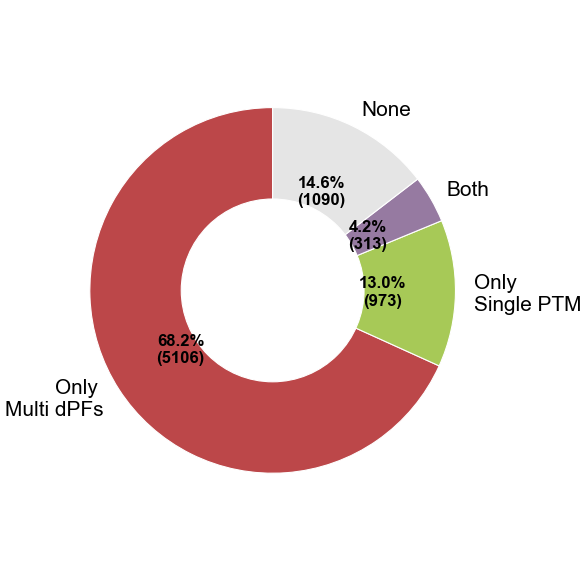

In [14]:
withSingleandMultidPFs = ((protein_info['N(dPFs)'] > 0) & (protein_info['N(PTM)'] > 0)).sum()
onlySinglePTM = ((protein_info['N(dPFs)'] == 0) & (protein_info['N(PTM)'] > 0)).sum()
onlyMultiPTM = ((protein_info['N(dPFs)'] > 0) & (protein_info['N(PTM)'] == 0)).sum()
print(f"Proteins with Single and Multi dPFs: {withSingleandMultidPFs}")
print(f"Proteins with only Single PTM: {onlySinglePTM}")
print(f"Proteins with only Multi dPFs: {onlyMultiPTM}")
print(f"Together: {withSingleandMultidPFs + onlySinglePTM + onlyMultiPTM}")
print(f"Total Proteins: {len(protein_info)}")

# Donut chart for the Protein numbers with No, Single, Multiple PTM Proteoforms
# Create a donut chart
data = [onlyMultiPTM, onlySinglePTM, withSingleandMultidPFs, (len(protein_info) - (onlyMultiPTM + onlySinglePTM + withSingleandMultidPFs))]
# Labels
labels = ["Only \nMulti dPFs", "Only \nSingle PTM", "Both", "None"]
# Colors
colors = ["#bc4749", "#a7c957", "#967aa1", "#e5e5e5"]

plots.donut_chart(
    data=data,
    labels=labels,
    colors=colors,
    circle_radius=0.5,
    save=True,
    filename="Proteins_Groups",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi
)

,None,only Single PTM,only Multi dPFs,Both
0,14.5778,13.0011,68.2255,4.1956


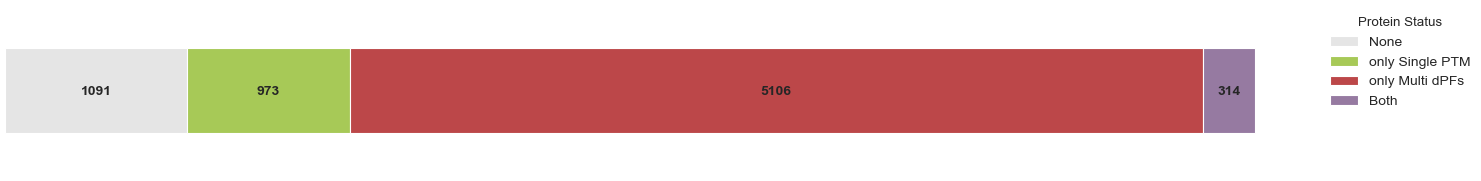

In [57]:
plot_data = pd.Series(
    {
        "None": (len(protein_info) - (onlyMultiPTM + onlySinglePTM + withSingleandMultidPFs)),
        "only Single PTM": onlySinglePTM,
        "only Multi dPFs": onlyMultiPTM,
        "Both": withSingleandMultidPFs,
        
    }
).to_frame().T

fig, ax = plt.subplots(figsize=(15, 2))
plot_data.plot(
    ax = ax,
    kind="barh",
    stacked=True,
    color={
        "None": "#e5e5e5",
        "only Single PTM": "#a7c957",
        "only Multi dPFs": "#bc4749",
        "Both": "#967aa1",
    },
)

plot_pct = plot_data.div(len(protein_info), axis=1) * 100
# Add the percentage as rotated within the bard centered from top (barh with stacked)
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.0f}",
        (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.),
        ha="center",
        va="center",
        xytext=(0, -1),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold"
    )

# Remove all the spines and labels etc.
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend(
    title="Protein Status",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=10
)

plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Proteins_Groups_Barplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

plot_pct

### Visualizing Number of Protein Forms Generated with ProteoForge

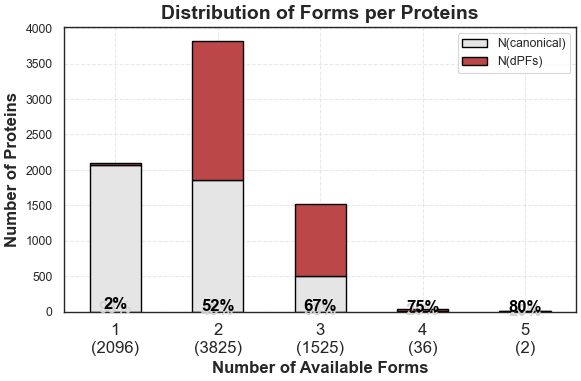

In [15]:
typeCounts = protein_info[['N(canonical)', 'N(dPFs)']]
proteoformCounts = typeCounts.sum(axis=1)

bar_counts = proteoformCounts.value_counts()
percentages = (typeCounts.div(proteoformCounts, axis=0) * 100)

# Prepare data for stacked bar plot
plot_data = pd.DataFrame({
    'Total': bar_counts,
    'N(canonical)': percentages['N(canonical)'].groupby(proteoformCounts).mean() / 100 * bar_counts,  # Calculate actual counts from percentages
    'N(dPFs)': percentages['N(dPFs)'].groupby(proteoformCounts).mean() / 100 * bar_counts  # Calculate actual counts from percentages
})

# Plotting
fig, ax = plt.subplots()

# Stacked bar plot
plot_data[['N(canonical)', 'N(dPFs)']].plot(
    kind='bar', stacked=True, ax=ax, color=['#e5e5e5', '#bc4749'],
    edgecolor='k', linewidth=1
)
plot_data_pct = plot_data[['N(canonical)', 'N(dPFs)']].div(plot_data['Total'], axis=0) * 100
# Add percentages that scale with the height of the bars
for i, (idx, row) in enumerate(plot_data_pct.iterrows()):
    ax.text(i, row['N(canonical)'] / 2, f"{row['N(canonical)']:.0f}%", ha='center', va='center', fontsize=12, fontweight='bold', color='lightgrey')
    ax.text(i, row['N(canonical)'] + row['N(dPFs)'] / 2, f"{row['N(dPFs)']:.0f}%", ha='center', va='center', fontsize=12, fontweight='bold', color='k')

ax.set_xlabel('Number of Available Forms', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Proteins', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Forms per Proteins', fontsize=14, fontweight='bold')
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Update the xticklabels with (text\n(Total))
ax.set_xticklabels(
    [f"{i}\n({j})" for i, j in zip(plot_data.index, plot_data['Total'])], 
    rotation=0, ha='center', va='top', fontsize=12
)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Proteoform_Distribution",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Exploring the Annotation of Proteoform Groups

### Single PTMs' UniProt Annotations 

In [16]:
codes_to_ignore = [
    'CHAIN', 'PEPTIDE', 'PROPEP', 'COILED', 'DOMAIN', 'REGION', 
    'REPEAT', 'HELIX', 'TURN', 'SITE', 'STRUCTURE', 'STRAND', 
    'TOPO_DOM', 'TRANSMEM', 'METAL', 'INTRAMEM'
]
# Get the single peptide PTMs matches
subset = expanded_info_data[expanded_info_data['ProteoformGroup'] == -1]
annot_data = uniprot_annotation.set_index("protein_id")[
    ['feature', 'start', 'end', 'note']
].rename(columns={"start": "startpos", "end": "endpos"})

res = {}
idx = -1
for i in subset.itertuples():
    idx += 1
    cur_protein = i.Protein
    st, en = i.startpos, i.endpos
    try: 
        sub_annot = annot_data.loc[cur_protein]
    except KeyError:
        # If the protein is not in the annotation 
        # set no annotation is available
        res[idx] = pd.DataFrame({
            'Protein': [cur_protein],
            'feature': ['No Annotation'], 
            'startpos': [pd.NA], 
            'endpos': [pd.NA], 
            'note': [pd.NA]
        })
        continue
    
    # Handle Series case
    if isinstance(sub_annot, pd.Series):
        sub_annot = sub_annot.to_frame().T  # Convert Series to DataFrame
    
    # If endpos is NA use startpos 
    sub_annot['endpos'] = sub_annot['endpos'].fillna(sub_annot['startpos'])
    # Extract relevant annotations
    relevant_annotations = sub_annot[
        ((sub_annot['startpos'] >= st) & (sub_annot['startpos'] <= en)) |
        ((sub_annot['endpos'] >= st) & (sub_annot['endpos'] <= en)) |
        ((sub_annot['startpos'] <= st) & (sub_annot['endpos'] >= en))
    ]
    # Remove the annotations that are not relevant
    # e.g. CHAIN, PEPTIDE, PROPEP, COILED, DOMAIN, REGION, REPEAT, HELIX, TURN, SITE, STRUCTURE
    # These are not relevant for PTM
    relevant_annotations = relevant_annotations[~relevant_annotations['feature'].isin(codes_to_ignore)]

    if relevant_annotations.empty:
        res[idx] = pd.DataFrame({
            'Protein': [cur_protein],
            'feature': ['No Annotation'], 
            'startpos': [pd.NA], 
            'endpos': [pd.NA], 
            'note': [pd.NA]
        })
        continue
    else:
        relevant_annotations['Protein'] = cur_protein
    res[idx] = relevant_annotations

# Concatenate all results into a single DataFrame
final_res = pd.concat(res.values(), keys=res.keys(), names=['protein_id']).reset_index(drop=True)
final_res['note'] = final_res['note'].fillna("")
final_res

,feature,startpos,endpos,note,Protein
0,DISULFID,43.0000,113.0000,,A0A075B6S2
1,DISULFID,41.0000,117.0000,,A0A0B4J1V6
2,VAR_SEQ,1.0000,593.0000,Missing (in isoform 5),A0FGR8
3,No Annotation,NaN,NaN,,A1L0T0
4,No Annotation,NaN,NaN,,A2RU67
...,...,...,...,...,...
2022,No Annotation,NaN,NaN,,Q9Y6I9
2023,No Annotation,NaN,NaN,,Q9Y6J0
2024,No Annotation,NaN,NaN,,Q9Y6M9
2025,No Annotation,NaN,NaN,,Q9Y6N8


Number of Proteins with No Annotation: 615


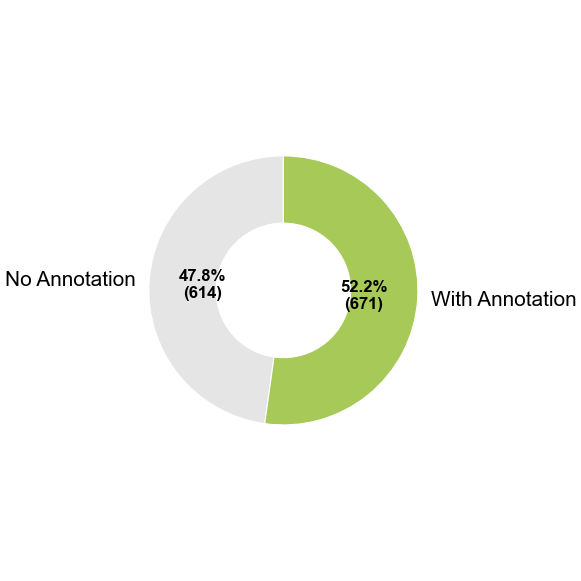

In [17]:
# Number of Proteins with No Annotation
no_annot_proteins = final_res[final_res['feature'] == 'No Annotation']['Protein'].unique()
print(f"Number of Proteins with No Annotation: {len(no_annot_proteins)}")
# Create a donut chart
data = [len(no_annot_proteins), len(singlePTM_proteins) - len(no_annot_proteins)]
# Labels
labels = ["No Annotation", "With Annotation"]
# Colors
colors = ["#e5e5e5", "#a7c957"]

_ = plots.donut_chart(
    data=data,
    labels=labels,
    colors=colors,
    circle_radius=0.5,
    save=True,
    filename="SinglePTM_Annotations_Donut",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi
)

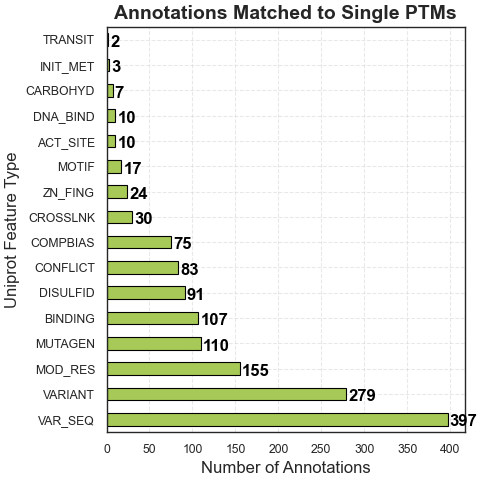

In [18]:
# Create a visualization to show the Number of Proteins with No-annotation
fig, ax = plt.subplots(figsize=(5, 5))
sub_data = final_res[final_res['feature'] != 'No Annotation']
# Create a bar plot
sub_data['feature'].value_counts().plot(kind='barh', color="#a7c957", ax=ax, edgecolor='black')
# Add counts to on top of the bars
for i, v in enumerate(sub_data['feature'].value_counts()):
    ax.text(
        # v, i, str(v),
        # Adjust the position of the text
        v + 2.5, i-0.1, str(v),
        color='black', 
        ha='left', va='center', 
        rotation=0, fontsize=12, fontweight='bold'
    )
ax.set_xlabel("Number of Annotations", fontsize=12)
ax.set_ylabel("Uniprot Feature Type", fontsize=12)
ax.set_title("Annotations Matched to Single PTMs", fontsize=14, fontweight='bold')
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
plt.tight_layout()

(sub_data.loc[sub_data['feature']=='MOD_RES', 'note'].str.split(';').str[0]).value_counts()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SinglePTM_Annotations",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Multiple PTMs' UniProt Annotations

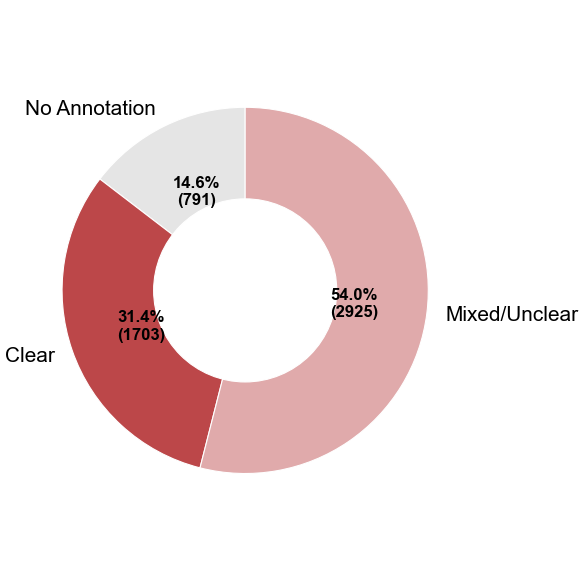

In [19]:
# subset for the dPFs
subset = expanded_info_data[expanded_info_data['ProteoformGroup'] > 0]
subset.head()

# Create a donut chart
data = [791, 1704, 2925]
# Labels
labels = ["No Annotation", "Clear", "Mixed/Unclear"]
# Colors
colors = ["#e5e5e5", "#bc4749", "#bc474975"]

plots.donut_chart(
    data=data,
    labels=labels,
    colors=colors,
    circle_radius=0.5,
    save=True,
    filename="MultiPTM_Annotations_Donut",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

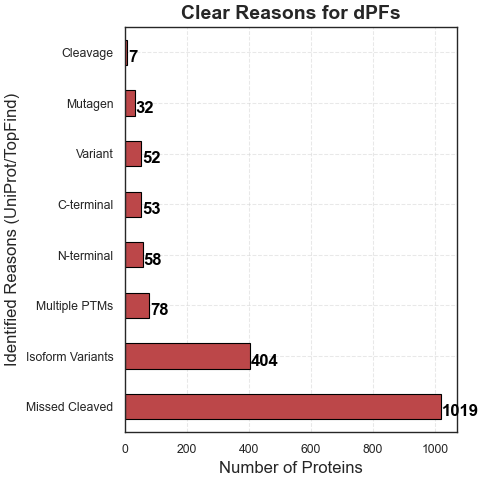

In [54]:
# Proteins with clear reasons of dPFs: 1703
data = [404, 7, 58, 53, 78, 1019, 52, 32]
labels = [
    "Isoform Variants",
    "Cleavage",
    "N-terminal",
    "C-terminal",
    "Multiple PTMs",
    "Missed Cleaved",
    "Variant",
    "Mutagen",
]

fig, ax = plt.subplots(figsize=(5, 5))
cnts = pd.Series(data, index=labels)
cnts.sort_values(ascending=False).plot(
    kind='barh', color="#bc4749", ax=ax, edgecolor='black'
)
# Add counts to on top of the bars
for i, v in enumerate(cnts.sort_values(ascending=False)):
    ax.text(
        v + 2.5, i-0.1, str(v),
        color='black', 
        ha='left', va='center', 
        rotation=0, fontsize=12, fontweight='bold'
    )
ax.set_xlabel("Number of Proteins", fontsize=12)
ax.set_ylabel("Identified Reasons (UniProt/TopFind)", fontsize=12)
ax.set_title("Clear Reasons for dPFs", fontsize=14, fontweight='bold')
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="MultiPTM_Annotations",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

# Generalized Way of Exploring the Data

## Building Functions

In [ ]:
from importlib import reload
reload(plots)
reload(utils);

In [205]:
cap_with_signf = protein_info[
    protein_info['isCAP'] & 
    (protein_info['isSignificant'] > 0)
]
print(f"Number of CAPs with significant peptides: {cap_with_signf.shape[0]}")
utils.view_table(
    cap_with_signf.sort_values(['seqLength']), 
    page_number=1
)


# iso_with_signf = protein_info[
#     protein_info['hasIsoforms'] & (protein_info['Significant%'] > 0)
# ].sort_values("seqLength", ascending=False)
# print(f"Number of Proteins with Isoforms and significant peptides: {iso_with_signf.shape[0]}")
# utils.view_table(
#     iso_with_signf, 
#     page_number=3
# )

# clv_with_signf = protein_info[
#     protein_info['Protein'].isin(candidate_proteins)
# ].sort_values("seqLength", ascending=False)
# print(f"Number of Proteins with Potential Proteolytic Activity: {clv_with_signf.shape[0]}")
# utils.view_table(
#     clv_with_signf, 
#     page_number=5
# )

Number of CAPs with significant peptides: 160
Total pages: 7, Current page: 1


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
1974,O15392,True,BIRC5,50.0000,142,6,1,True,16.6667,1,0,1
3634,P21741,True,MDK,60.8392,143,8,1,True,12.5000,1,1,0
508,P42773,True,CDKN2C,32.1429,168,4,1,False,25.0000,1,1,0
4115,P01111,True,NRAS,59.7884,189,9,1,False,11.1111,1,1,0
3659,P61586,True,RHOA,39.8964,193,8,1,False,12.5000,1,1,0
3962,P06730,True,EIF4E,58.9862,217,9,1,True,11.1111,1,1,0
1592,P10415,True,BCL2,47.6987,239,5,1,True,20.0000,1,1,0
1252,P51580,True,TPMT,65.3061,245,10,2,False,20.0000,1,1,0
4189,P27707,True,DCK,42.6923,260,9,1,False,11.1111,1,1,0
6124,P06748,True,NPM1,73.1293,294,20,1,True,5.0000,1,1,0


Current Protein: P11802


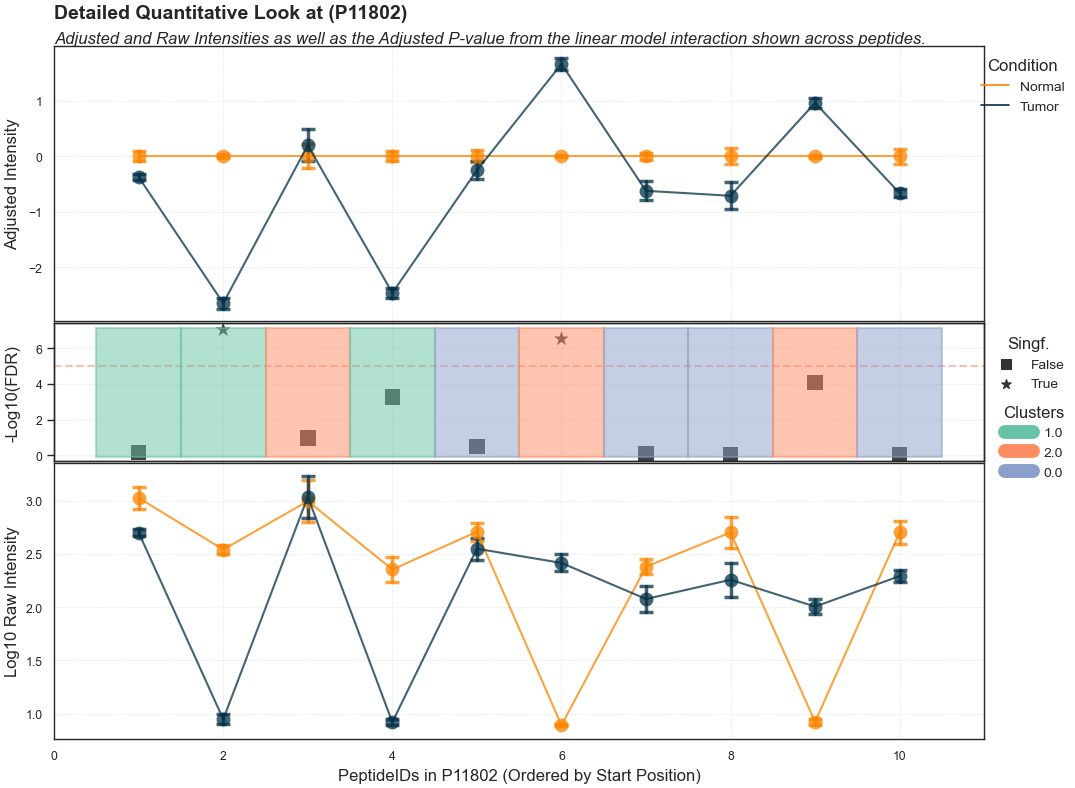

In [ ]:
current_protein = 'P11802'

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
_ = plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
    # save=True,
    filename=f"{current_protein}_PeptideClusters",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [218]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
23036,P11802,YEPVAEIGVGAYGTVYK,Cyclin-dependent kinase 4,CDK4,5,22,303,0,57.7558,True,1,Down,0.5472,0.7083,False,1.0000,4
23037,P11802,ARDPHSGHFVALK,Cyclin-dependent kinase 4,CDK4,22,35,303,0,57.7558,True,2,Down,0.0000,0.0000,True,1.0000,4
23038,P11802,RLEAFEHPNVVR,Cyclin-dependent kinase 4,CDK4,61,73,303,0,57.7558,True,3,Up,0.0416,0.1084,False,2.0000,6
23039,P11802,EIKVTLVFEHVDQDLR,Cyclin-dependent kinase 4,CDK4,85,101,303,0,57.7558,True,4,Down,0.0001,0.0005,False,1.0000,4
23040,P11802,VTLVFEHVDQDLR,Cyclin-dependent kinase 4,CDK4,88,101,303,1,57.7558,True,5,Down,0.1648,0.3121,False,0.0000,5
23041,P11802,APPPGLPAETIK,Cyclin-dependent kinase 4,CDK4,106,118,303,0,57.7558,True,6,Up,0.0000,0.0000,True,2.0000,6
23042,P11802,GLDFLHANCIVHR,Cyclin-dependent kinase 4,CDK4,126,139,303,0,57.7558,True,7,Down,0.7407,0.8480,False,0.0000,5
23043,P11802,DLKPENILVTSGGTVK,Cyclin-dependent kinase 4,CDK4,139,155,303,0,57.7558,True,8,Down,0.9012,0.9467,False,0.0000,5
23044,P11802,RKPLFCGNSEADQLGK,Cyclin-dependent kinase 4,CDK4,209,225,303,0,57.7558,True,9,Up,0.0000,0.0001,False,2.0000,6
23045,P11802,IFDLIGLPPEDDWPR,Cyclin-dependent kinase 4,CDK4,225,240,303,0,57.7558,True,10,Down,0.7857,0.8775,False,0.0000,0


In [216]:
utils.view_table(
    uniprot_annotation.loc[
        (uniprot_annotation["protein_id"] == current_protein) 
        # &
        # (uniprot_annotation['feature'] == 'VAR_SEQ')
    ].sort_values(["start", "end"]),
    page_number=3
)

Total pages: 3, Current page: 3


,protein_id,feature,isoform_id,start,end,note
26079,O15392,MOD_RES,,110.0000,NaN,N6-acetyllysine
26080,O15392,MOD_RES,,112.0000,NaN,N6-acetyllysine
26090,O15392,VAR_SEQ,,114.0000,142.0000,AKETNNKKKEFEETAKKVRRAIEQLAAMD -> ERALLAE (in i...
26081,O15392,MOD_RES,,115.0000,NaN,N6-acetyllysine
26082,O15392,MOD_RES,,117.0000,NaN,Phosphothreonine; by AURKB
26109,O15392,MUTAGEN,,117.0000,NaN,T->A: Prevents phosphorylation by AURKB. Still...
26110,O15392,MUTAGEN,,117.0000,NaN,T->E: Mimics phosphorylation. Disrupts subcell...
26083,O15392,MOD_RES,,121.0000,NaN,N6-acetyllysine
26073,O15392,SITE,,126.0000,NaN,Interaction with FBXL7
26111,O15392,MUTAGEN,,126.0000,NaN,E->A: Loss of FBXL7 binding.


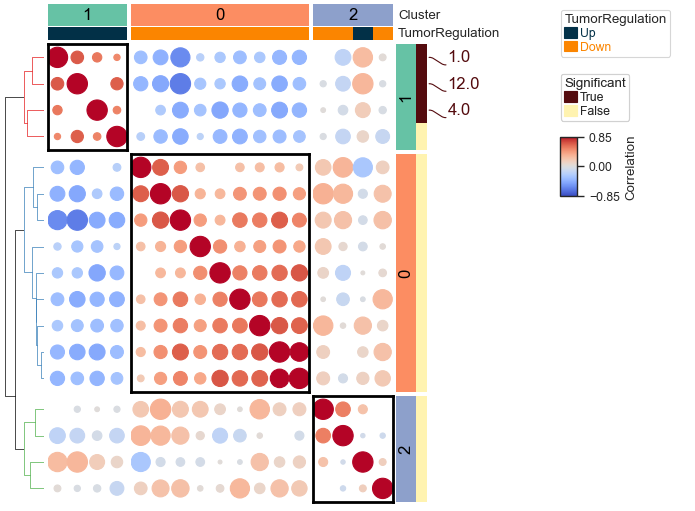

In [66]:
from importlib import reload
reload(plots)

## Heatmap with Clusters
_ = plots.heatmap_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    hue_col='TumorRegulation',
    hue_palette=regulation_colors,
    corrMethod='kendall',
    distanceMetric='euclidean',
    linkageMethod='ward',
    save=False,
)

### Protein Intensity Comparison

In [67]:
pfgs = expanded_info_data.loc[
    expanded_info_data["Protein"] == current_protein,
    ['PeptideID', 'ProteoformGroup']
].set_index('PeptideID').to_dict()['ProteoformGroup']

protein_subset = results_df[
    (results_df["Protein"] == current_protein)
]
protein_subset['pfg'] = protein_subset['PeptideID'].map(pfgs)

# Calculate the value counts outside the function
pfg_counts = pd.Series(pfgs).value_counts()

def modify_pfg(x):
    # If pfg is -1 return 'C'
    if x == -1:
        return 'Can_0'
    else:
        # If pfg occurs more than once return keep the number
        if pfg_counts[x] > 1:
            return f"Pfm_{x}"
        else:
            # If pfg is unique return 'C'
            return f'Ptm_{x}'
        
protein_subset['pfg'] = protein_subset['pfg'].map(modify_pfg)

protein_subset['proteoform_id'] = protein_subset['Protein'] + "\n" + protein_subset['pfg']
x = protein_subset[[
    'Protein', 'Peptide', 'PeptideID', 'cluster_id', 'adj.pvalue', 'isSignificant', 'pfg', 'proteoform_id'
]].drop_duplicates()
utils.view_table(x.sort_values(['cluster_id', 'PeptideID']), page_number=None)
# protein_subset.head()

Total pages: 1


,Protein,Peptide,PeptideID,cluster_id,adj.pvalue,isSignificant,pfg,proteoform_id
58918,Q6P996,YEDFVVDGFNVLYNK,2,0,0.2878,False,Can_0,Q6P996\nCan_0
58919,Q6P996,GRLPLLLVANAGTAAVGHTDK,3,0,0.0982,False,Can_0,Q6P996\nCan_0
58921,Q6P996,ILVEDELSSPVVVFR,5,0,0.0556,False,Can_0,Q6P996\nCan_0
58922,Q6P996,AVPVPNMTPSGVGR,6,0,0.1987,False,Can_0,Q6P996\nCan_0
58924,Q6P996,GEDVDQLVACIESK,8,0,0.3220,False,Can_0,Q6P996\nCan_0
58925,Q6P996,SDPEGENIHAGLLK,9,0,0.0624,False,Can_0,Q6P996\nCan_0
58927,Q6P996,LLENMTEVVRK,11,0,0.0069,False,Can_0,Q6P996\nCan_0
58930,Q6P996,TFNLTAGSLESTEPIYVYK,14,0,0.6025,False,Can_0,Q6P996\nCan_0
58932,Q6P996,GSDALSETSSVSHIEDLEK,16,0,0.0194,False,Can_0,Q6P996\nCan_0
58917,Q6P996,IADPTLAEMGK,1,1,0.0000,True,Pfm_1,Q6P996\nPfm_1


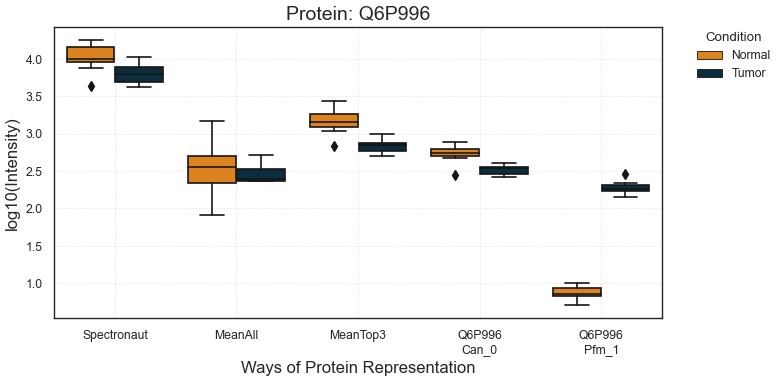

In [68]:
plot_data = spct_protein_data.loc[current_protein].reset_index()
plot_data.columns = ['UniqueNames', 'Intensity']
plot_data['Protein'] = current_protein
plot_data['log10(Intensity)'] = np.log10(plot_data['Intensity'])
plot_data['Condition'] = plot_data['UniqueNames'].map(unique_group_dict)
plot_data['Type'] = 'Spectronaut'

## Calculate the protein quantifications

# Using mean of all real peptides (non-imputed)
tmp = protein_subset[
    protein_subset['isReal']
].groupby( ['Protein', 'Sample'] ).agg({
    'Condition': 'first',
    'Intensity': 'mean',
    'log10(Intensity)': 'mean'
}).reset_index()
tmp['Type'] = "MeanAll"

# Using mean of top 3 peptides (can be imputed)
tmp2 = protein_subset.groupby( ['Protein', 'Sample'] ).apply(
    lambda x: x.nlargest(3, 'log10(Intensity)')
).reset_index(drop=True)
tmp2 = tmp2.groupby( ['Protein', 'Sample'] ).agg({
    'Condition': 'first',
    'Intensity': 'mean',
    'log10(Intensity)': 'mean'
}).reset_index()
tmp2['Type'] = "MeanTop3"

# Using the proteoform_ids and meanALL of the peptides
tmp3 = protein_subset.groupby( ['proteoform_id', 'Sample'] ).agg({
    'Condition': 'first',
    'Intensity': 'mean',
    'log10(Intensity)': 'mean'
}).reset_index()
tmp3['Protein'] = current_protein
tmp3['Type'] = tmp3['proteoform_id']
tmp3.drop(columns=['proteoform_id'], inplace=True)

plot_data = pd.concat([plot_data, tmp, tmp2, tmp3], axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    ax=ax,
    x='Type',
    y='log10(Intensity)',
    data=plot_data,
    palette=status_colors,
    hue='Condition',
    showfliers=True,
)

ax.set_title(f"Protein: {current_protein}", fontsize=14)
ax.set_ylabel("log10(Intensity)", fontsize=12)
ax.set_xlabel("Ways of Protein Representation", fontsize=12)

# Put the legend out of the figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Condition', frameon=False)
ax.grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")
plt.tight_layout()

# # Save the figure
# plots.save_figures(
#     plt.gcf(),
#     filename=f"{current_protein}_ProteinQuantification",
#     filepath=figure_path,
#     fileformat=figure_formats,
#     dpi=figure_dpi,
#     transparent=transparet_bg,
# )

### 

In [281]:
# Check the COPF
copf_results = feather.read_dataframe(f"{input_path}COPF_NBResults.feather")
copf_results

,protein_id,proteoform_score_pval,id,n_peptides,cluster,proteoform_score,proteoform_score_z,proteoform_score_dz,proteoform_score_pval_adj,proteoform_id,n_proteoforms,Protein,Peptide
0,A0A075B6K5,NaN,A0A075B6K5-DSNRPSGIPER,4,100.0000,NaN,NaN,NaN,NaN,A0A075B6K5,0,A0A075B6K5,DSNRPSGIPER
1,A0A075B6K5,NaN,A0A075B6K5-FSGSNSGNTATLTISR,4,100.0000,NaN,NaN,NaN,NaN,A0A075B6K5,0,A0A075B6K5,FSGSNSGNTATLTISR
2,A0A075B6K5,NaN,A0A075B6K5-ITCGGNNIGSK,4,100.0000,NaN,NaN,NaN,NaN,A0A075B6K5,0,A0A075B6K5,ITCGGNNIGSK
3,A0A075B6K5,NaN,A0A075B6K5-PGQAPVLVIYR,4,100.0000,NaN,NaN,NaN,NaN,A0A075B6K5,0,A0A075B6K5,PGQAPVLVIYR
4,A0A075B6S2,0.1126,A0A075B6S2-FSGSGSGTDFTLK,4,1.0000,0.5300,0.5442,1.5867,0.2152,A0A075B6S2,1,A0A075B6S2,FSGSGSGTDFTLK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94446,Q9Y6Y8,0.0078,Q9Y6Y8-VANQIKEEEEK,24,1.0000,0.8543,0.9132,2.6624,0.0349,Q9Y6Y8,1,Q9Y6Y8,VANQIKEEEEK
94447,Q9Y6Y8,0.0078,Q9Y6Y8-VEFLPVHWHSSLGGDATGVDR,24,2.0000,0.8543,0.9132,2.6624,0.0349,Q9Y6Y8,1,Q9Y6Y8,VEFLPVHWHSSLGGDATGVDR
94448,Q9Y6Y8,0.0078,Q9Y6Y8-VGMEINHLHALFMSR,24,1.0000,0.8543,0.9132,2.6624,0.0349,Q9Y6Y8,1,Q9Y6Y8,VGMEINHLHALFMSR
94449,Q9Y6Y8,0.0078,Q9Y6Y8-VIVQFQPSSVPDEWGTTQDGQTRPR,24,2.0000,0.8543,0.9132,2.6624,0.0349,Q9Y6Y8,1,Q9Y6Y8,VIVQFQPSSVPDEWGTTQDGQTRPR


In [313]:
# Find the unique proteoform_id's for the protein
x = copf_results.groupby('Protein')['proteoform_id'].nunique()
x = x[x > 1]
print(f"Number of Proteins with multiple ProteoformGroups: {len(x)}")

Number of Proteins with multiple ProteoformGroups: 672


In [316]:
# Check the overlap between the COPF and the ProteoForge

# Compare the proteins with significance and COPF's proteoforms
proteins_with_significance = set(proteinsWithSignf)
copf_proteins_set = set(x.index)

# Find the intersection
overlap_proteins = proteins_with_significance.intersection(copf_proteins_set)
print(f"Number of overlapping proteins: {len(overlap_proteins)}")

# Find the proteins only in significance set
only_significance_proteins = proteins_with_significance - copf_proteins_set
print(f"Number of proteins only in significance set: {len(only_significance_proteins)}")

# Find the proteins only in COPF set
only_copf_proteins = copf_proteins_set - proteins_with_significance
print(f"Number of proteins only in COPF set: {len(only_copf_proteins)}")

print("Only in COPF:")
print(only_copf_proteins)

Number of overlapping proteins: 658
Number of proteins only in significance set: 5191
Number of proteins only in COPF set: 14
Only in COPF:
{'Q9BUK6', 'Q9H4M7', 'Q9H4G4', 'Q99933', 'Q6PHR2', 'P51161', 'O75943', 'O43157', 'Q99569', 'Q9BXI3', 'Q9Y3C1', 'O60583', 'O15427', 'Q13625'}


Current Protein: Q13625


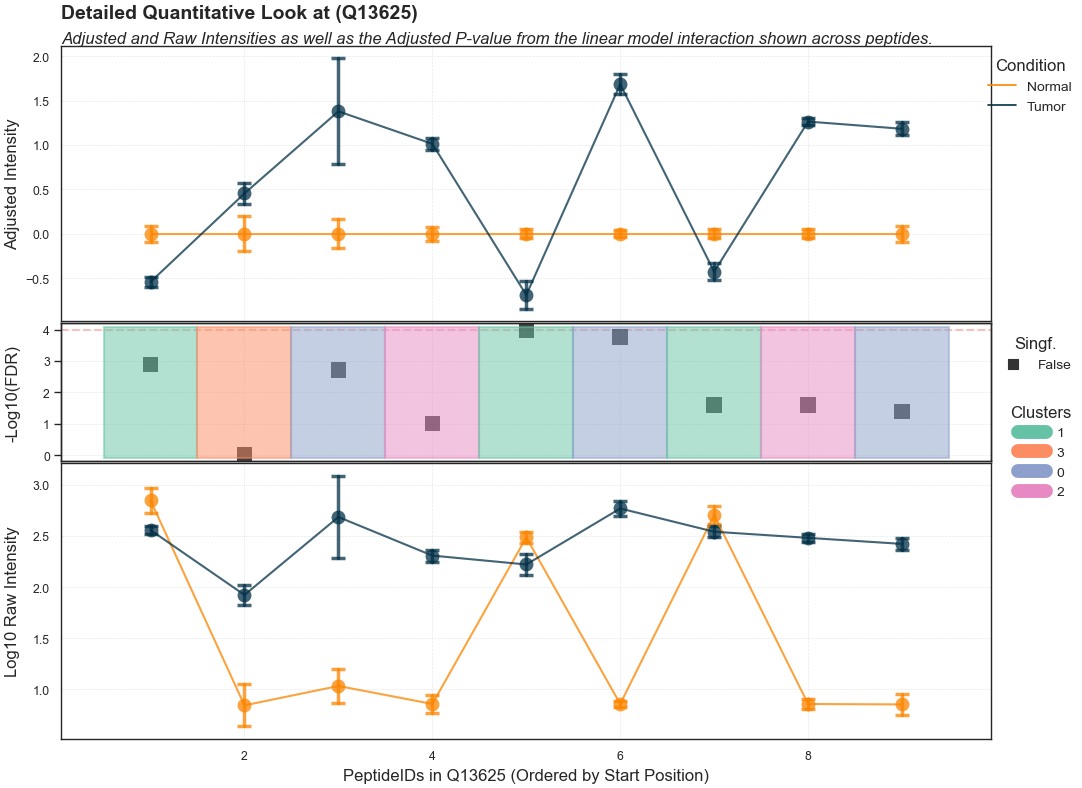

In [332]:
current_protein = 'Q13625'

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
)

In [327]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,cluster_id,ProteoformGroup
75170,Q99569,PAPEQASLVEEGQPQTR,Plakophilin-4,PKP4,1,18,1192,0,39.1779,False,1,Down,0.0005,0.0023,False,0,-1
75171,Q99569,QIVASQLER,Plakophilin-4,PKP4,59,68,1192,0,39.1779,False,2,Up,0.0000,0.0001,False,1,-1
75172,Q99569,LGAESPSIASTSSTEK,Plakophilin-4,PKP4,70,86,1192,0,39.1779,False,3,Down,0.0003,0.0014,False,0,-1
75173,Q99569,AEGQTLVQPSVANR,Plakophilin-4,PKP4,193,207,1192,0,39.1779,False,4,Down,0.7488,0.8336,False,2,-1
75174,Q99569,AQSPSYVISTGVSPSR,Plakophilin-4,PKP4,218,234,1192,0,39.1779,False,5,Down,0.9934,0.9959,False,0,-1
75175,Q99569,VGSPLTLTDAQTR,Plakophilin-4,PKP4,311,324,1192,0,39.1779,False,6,Down,0.3881,0.5319,False,2,-1
75176,Q99569,VASPSQGQVGSSSPK,Plakophilin-4,PKP4,324,339,1192,0,39.1779,False,7,Down,0.7759,0.8529,False,0,-1
75177,Q99569,MVPPRPDSLTGLR,Plakophilin-4,PKP4,374,387,1192,0,39.1779,False,8,Up,0.0001,0.0003,False,1,-1
75178,Q99569,SSYASQHSQLGQDLR,Plakophilin-4,PKP4,387,402,1192,0,39.1779,False,9,Down,0.0007,0.0028,False,0,-1
75179,Q99569,SAVSPDLHITPIYEGR,Plakophilin-4,PKP4,402,418,1192,0,39.1779,False,10,Down,0.7650,0.8452,False,0,-1


In [326]:
utils.view_table(
    uniprot_annotation.loc[
        (uniprot_annotation["protein_id"] == current_protein) 
        # &
        # (uniprot_annotation['feature'] == 'VAR_SEQ')
    ].sort_values(["start", "end"]),
    page_number=1
)

Total pages: 3, Current page: 1


,protein_id,feature,isoform_id,start,end,note
493174,Q99569,REGION,,1.0000,31.0000,Disordered
493164,Q99569,CHAIN,,1.0000,1192.0000,Plakophilin-4
493181,Q99569,COMPBIAS,,10.0000,31.0000,Polar residues
493180,Q99569,COILED,,36.0000,70.0000,
493222,Q99569,CONFLICT,,41.0000,NaN,V -> M (in Ref. 3; AAH50308)
493175,Q99569,REGION,,73.0000,262.0000,Disordered
493182,Q99569,COMPBIAS,,75.0000,262.0000,Polar residues
493185,Q99569,MOD_RES,,75.0000,NaN,Phosphoserine
493186,Q99569,MOD_RES,,84.0000,NaN,Phosphothreonine
493187,Q99569,MOD_RES,,106.0000,NaN,Phosphoserine
